<a href="https://colab.research.google.com/github/agayev169/pytorch_examples/blob/master/cgan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## GPU

In [1]:
!nvidia-smi

Sun Jan  5 16:42:30 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.44       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P0    26W /  75W |      0MiB /  7611MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

## Imports

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import time
import numpy as np

## Constants

In [0]:
device = "cuda" if torch.cuda.is_available() else "cpu"
batch_size = 64
epochs_n   = 50
lr         = 0.0002

## Model

### Discriminator

In [0]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv1    = nn.Conv2d(1, 32, 4, 2, 1)
        self.conv2    = nn.Conv2d(32, 64, 4, 2, 1)
        self.bn2      = nn.BatchNorm2d(64)
        self.conv3    = nn.Conv2d(64, 128, 4, 2, 1)
        self.bn3      = nn.BatchNorm2d(128)
        self.conv4    = nn.Conv2d(128, 256, 4, 2, 1)
        self.fc1      = nn.Linear(256 + 10, 128)
        self.bn4      = nn.BatchNorm1d(128)
        self.fc2      = nn.Linear(128, 1)

    
    def forward(self, x, y):
        x = self.conv1(x)                # x, 32, 14, 14
        x = F.relu(x)
        x = self.conv2(x)                # x, 64, 7, 7
        x = self.bn2(x)
        x = F.relu(x)
        x = self.conv3(x)                # x, 128, 3, 3
        x = self.bn3(x)
        x = F.relu(x)
        x = self.conv4(x)                # x, 256, 1, 1
        x = F.sigmoid(x)

        mini_batch = x.size()[0]
        y = y.view(-1, 10)               # x, 10
        x = x.view(mini_batch, -1)       # x, 256
        x = torch.cat((x, y), 1)         # x, 256 + 10

        x = self.fc1(x)                  # x, 128
        x = self.bn4(x)
        x = torch.relu(x)
        x = self.fc2(x)                  # x, 1
        x = torch.sigmoid(x)
        return x.view(-1, 1).squeeze(1)

### Generator

In [0]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.conv1_t_1  = nn.ConvTranspose2d(100 + 10, 1024, 5, 1, 0)
        self.bn1_1      = nn.BatchNorm2d(1024)
        self.conv2_t_1  = nn.ConvTranspose2d(1024, 512, 4, 2, 0)
        self.bn2_1      = nn.BatchNorm2d(512)
        self.conv3_t    = nn.ConvTranspose2d(512 + 0, 128, 4, 2, 0)
        self.bn3        = nn.BatchNorm2d(128)
        self.conv4_t    = nn.ConvTranspose2d(128, 1, 3, 1, 0)


    def forward(self, x, y):                 # x: x, 100, 1, 1, y: x, 10, 1, 1
        x = torch.cat((x, y), 1)             # x: x, 110, 1, 1

        x = self.conv1_t_1(x)                # x, 1024, 5, 5
        x = self.bn1_1(x)
        x = F.relu(x)
        x = self.conv2_t_1(x)                # x, 512, 12, 12
        x = self.bn2_1(x)
        x = F.relu(x)
        x = self.conv3_t(x)                  # x, 128, 26, 26
        x = self.bn3(x)
        x = F.relu(x)
        x = self.conv4_t(x)                  # x, 1, 28, 28
        x = torch.tanh(x)
        return x


### Weights initialization

In [0]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

### Test

### Train

In [0]:
def train(generator, discriminator, device, train_loader, opt_gen, opt_disc, epochs_n, criterion=None, criterion_sum=None):
    if not criterion:
        criterion = nn.BCELoss()
    
    if not criterion_sum:
        criterion_sum = nn.BCELoss(reduction="sum")

    y_template = torch.zeros(10, 10, 1, 1)
    for i in range(10):
        y_template[i, i] = 1

    fixed_noise = torch.normal(mean=0, std=1, size=(10, 100, 1, 1)).to(device)
    # fixed_label = torch.rand(size=(10, 10, 1, 1)).to(device)
    fixed_label = (y_template[[i for i in range(10)]]).to(device)
    results = np.empty(shape=(epochs_n + 1, 10, 28, 28))
    results[0] = generator(fixed_noise, fixed_label).to("cpu").detach().numpy().reshape(10, 28, 28)

    loss_gen_hist  = []
    loss_disc_hist = []

    for epoch in range(epochs_n):
        epoch_begin = time.time()

        total_loss_gen  = 0
        total_loss_disc = 0

        D_x = 0
        D_z = 0

        for x, y in train_loader:

            fake_labels = torch.zeros(x.size()[0]).to(device)
            real_labels = torch.ones (x.size()[0]).to(device)

            # generator
            opt_gen.zero_grad()
            z = torch.normal(mean=0, std=1, size=(x.size()[0], 100, 1, 1)).to(device)
            y_gen = (y_template[y]).to(device)
            gen_out = generator(z, y_gen)
            disc_out = discriminator(gen_out, y_gen)
            D_z += np.sum(disc_out.to("cpu").detach().numpy())
            loss_gen = criterion(disc_out, real_labels)
            total_loss_gen += criterion_sum(disc_out, real_labels).item()

            loss_gen.backward()
            opt_gen.step()

            # discriminator
            opt_disc.zero_grad()
            x = x.to(device)
            y = (y_template[y]).to(device)
            disc_out_real = discriminator(x, y)
            D_x += np.sum(disc_out_real.to("cpu").detach().numpy())
            loss_disc_real = criterion(disc_out_real, real_labels)
            total_loss_disc += criterion_sum(disc_out_real, real_labels).item()

            disc_out_fake = discriminator(gen_out.detach(), y_gen)
            loss_disc_fake = criterion(disc_out_fake, fake_labels)
            total_loss_disc += criterion_sum(disc_out_fake, fake_labels).item()

            disc_total_loss = loss_disc_fake + loss_disc_real
            disc_total_loss.backward()
            opt_disc.step()

            loss_gen_hist.append(loss_gen.item())
            loss_disc_hist.append(loss_disc_real.item() + loss_disc_fake.item())

        D_z /= len(train_loader.dataset)
        D_x /= len(train_loader.dataset)


        total_loss_gen  = total_loss_gen  / len(train_loader.dataset)
        total_loss_disc = total_loss_disc / len(train_loader.dataset)

        results[epoch + 1] = generator(fixed_noise, fixed_label).to("cpu").detach().numpy().reshape(10, 28, 28)
        
        epoch_time = time.time() - epoch_begin
        print(f"TRAIN --- epoch: {(epoch + 1):3d} --- generator loss: {total_loss_gen:.6f} --- discriminator loss: {total_loss_disc:.6f} --- D_x: {D_x:.3f} --- D_z: {D_z:.3f} --- time: {epoch_time:.4f}")
        epoch += 1

    return results, loss_gen_hist, loss_disc_hist

## Generate

In [0]:
def generate(generator, imgs_n, digits, device):
    if not isinstance(digits, (list, tuple, np.ndarray, int)):
        raise AssertionError("digits must be an integer or a list/tuple/numpy.ndarray of the size of imgs_n")

    if isinstance(digits, (list, tuple, np.ndarray)) and len(digits) != imgs_n:
        raise AssertionError("The length of the digits list must be the same with the number of images or it must be an integer")

    if isinstance(digits, int):
        digits = torch.zeros(imgs_n, dtype=int) + digits

    z = torch.normal(mean=0, std=1, size=(imgs_n, 100, 1, 1)).to(device)
    y_template = torch.zeros(10, 10, 1, 1)
    for i in range(10):
        y_template[i, i] = 1
    
    y = (y_template[digits]).to(device)
    
    return generator(z, y)

## Data

In [0]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST("data/", train=True, download=True,
                  transform=transforms.Compose([
                                                transforms.ToTensor(),
                                                transforms.Normalize((0.5,), (0.5,))
                  ])),
                  batch_size=batch_size, shuffle=True
    )

## Training

In [10]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

generator.train()
discriminator.train()

generator.apply(weights_init)
discriminator.apply(weights_init)

opt_gen  = optim.Adam(    generator.parameters(), lr=lr, betas=(0.5, 0.999))
opt_disc = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

imgs, loss_gen, loss_disc = train(generator, discriminator, device, train_loader, opt_gen, opt_disc, epochs_n)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


TRAIN --- epoch:   1 --- generator loss: 1.038474 --- discriminator loss: 0.953733 --- D_x: 0.631 --- D_z: 0.370 --- time: 122.3885
TRAIN --- epoch:   2 --- generator loss: 1.046088 --- discriminator loss: 0.973621 --- D_x: 0.627 --- D_z: 0.371 --- time: 126.0981
TRAIN --- epoch:   3 --- generator loss: 1.013322 --- discriminator loss: 1.017363 --- D_x: 0.615 --- D_z: 0.384 --- time: 126.0097
TRAIN --- epoch:   4 --- generator loss: 1.000719 --- discriminator loss: 1.041863 --- D_x: 0.609 --- D_z: 0.390 --- time: 126.0733
TRAIN --- epoch:   5 --- generator loss: 1.013101 --- discriminator loss: 1.036012 --- D_x: 0.613 --- D_z: 0.388 --- time: 126.1296
TRAIN --- epoch:   6 --- generator loss: 1.020954 --- discriminator loss: 1.035013 --- D_x: 0.614 --- D_z: 0.386 --- time: 126.4120
TRAIN --- epoch:   7 --- generator loss: 1.061936 --- discriminator loss: 1.003684 --- D_x: 0.625 --- D_z: 0.375 --- time: 127.1224
TRAIN --- epoch:   8 --- generator loss: 1.113634 --- discriminator loss: 0.

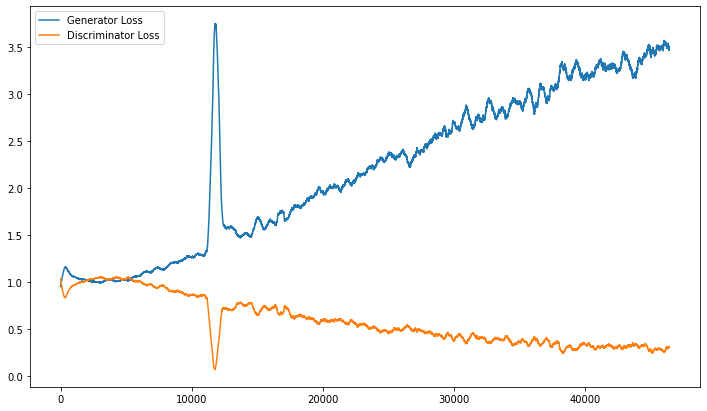

In [11]:
plt.figure(figsize=(12, 7))
plt.plot(np.convolve(loss_gen , [1/500] * 500, mode="valid"), label="Generator Loss")
plt.plot(np.convolve(loss_disc, [1/500] * 500, mode="valid"), label="Discriminator Loss")
plt.legend()

## Generating images

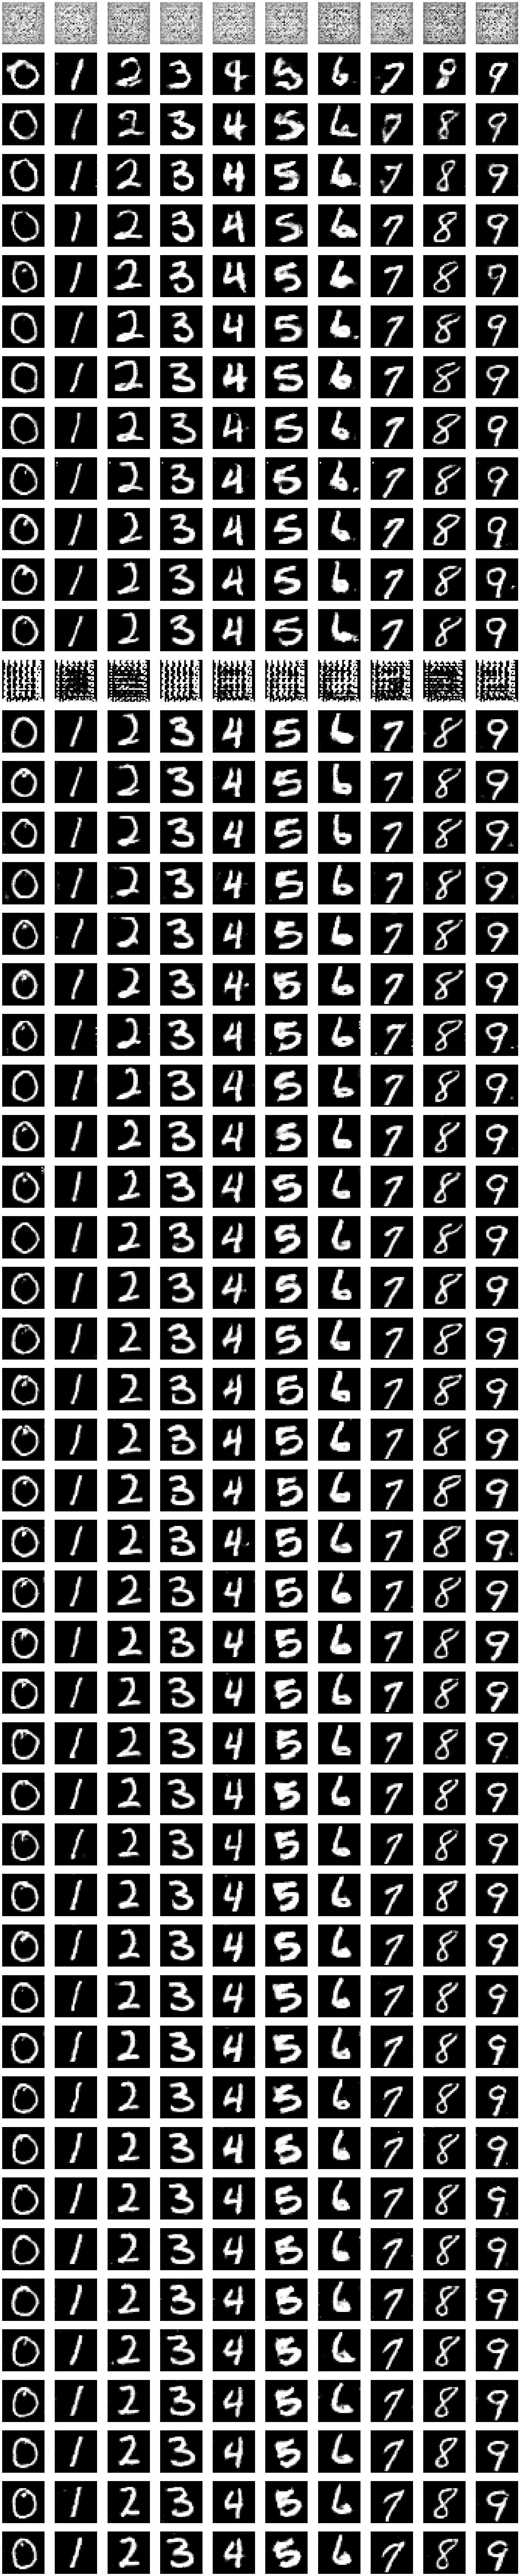

In [12]:
fig, ax = plt.subplots(len(imgs), 10, figsize=(10 * 3, len(imgs) * 3))

for i in range(len(imgs) * 10):
    ax[i // 10, i % 10].imshow(imgs[i // 10][i % 10], cmap="gray")
    ax[i // 10, i % 10].axis("off")

In [0]:
digits = [i // 10 for i in range(100)]
imgs = generate(generator, 100, digits, device).cpu().detach().numpy().reshape(-1, 28, 28)

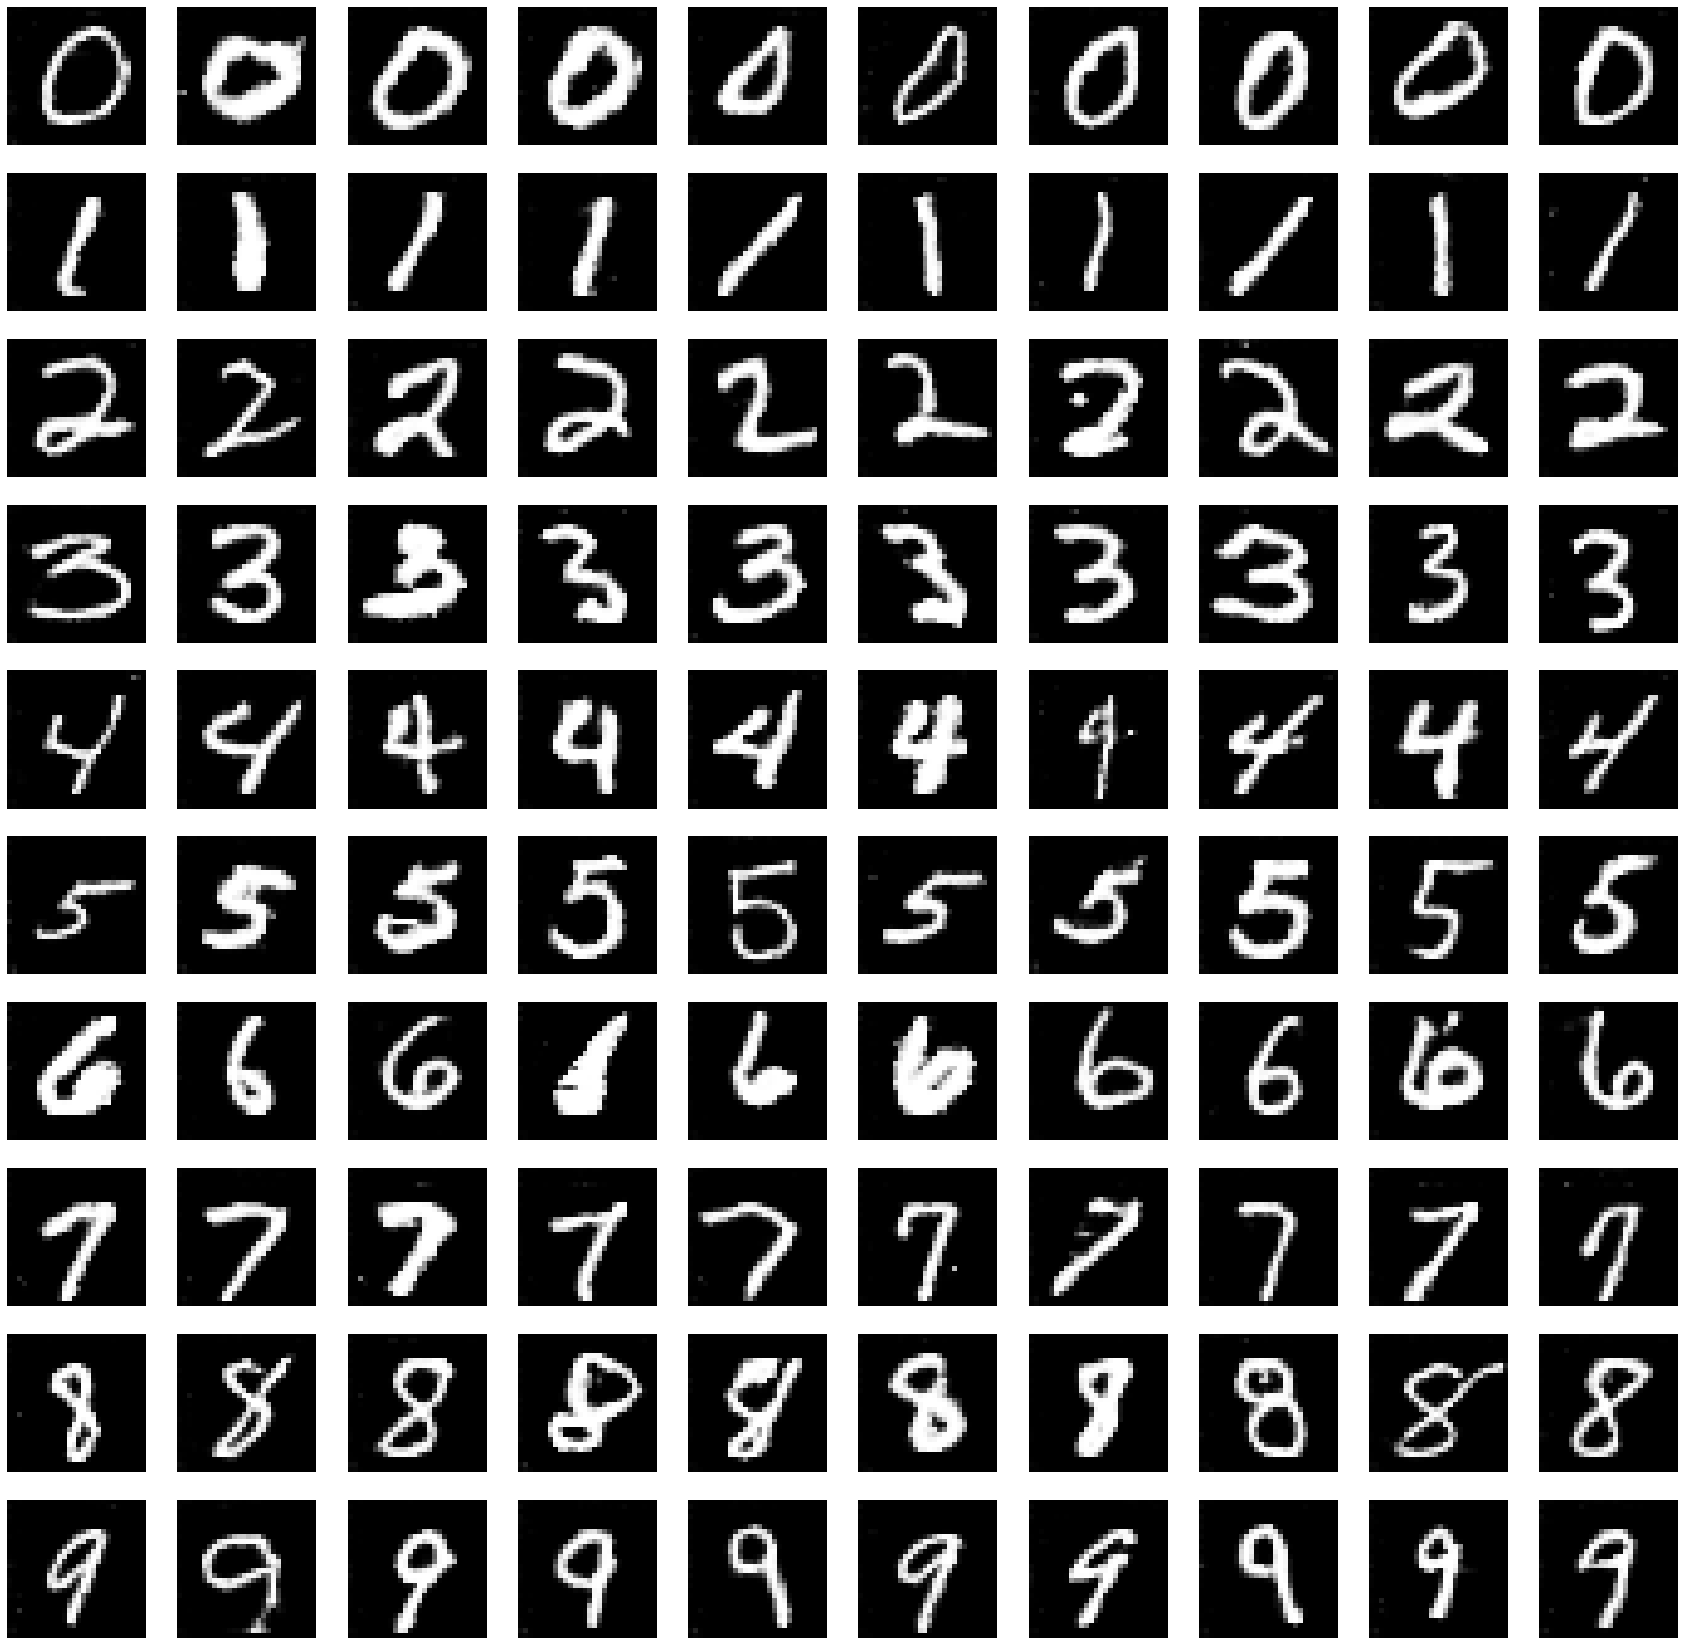

In [14]:
fig, ax = plt.subplots(10, 10, figsize=(30, 30))

for i in range(100):
    ax[i // 10, i % 10].imshow(imgs[i], cmap="gray")
    ax[i // 10, i % 10].axis("off")